In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

df = pd.read_csv('all_XG_data.csv')
df = df.loc[:, ~df.columns.str.endswith('_speed')]

df = df.drop(columns=['Time', 'Half'])

# Calculate total distance of all players to the ball
for i in range(1, 12):
    df[f'us_{i}_ball_dist'] = np.sqrt((df[f'us_{i}_x'] - df['ball_x'])**2 + (df[f'us_{i}_y'] - df['ball_y'])**2)
    df[f'them_{i}_ball_dist'] = np.sqrt((df[f'them_{i}_x'] - df['ball_x'])**2 + (df[f'them_{i}_y'] - df['ball_y'])**2)

# Optionally, drop the original x/y columns if you only want the distances
player_xy_cols = [f'us_{i}_x' for i in range(1, 12)] + [f'us_{i}_y' for i in range(1, 12)] + \
                 [f'them_{i}_x' for i in range(1, 12)] + [f'them_{i}_y' for i in range(1, 12)]
df = df.drop(columns=player_xy_cols)

df.head()
#df.shape


,XG,ball_x,ball_y,ball_z,us_1_ball_dist,them_1_ball_dist,us_2_ball_dist,them_2_ball_dist,us_3_ball_dist,them_3_ball_dist,...,us_7_ball_dist,them_7_ball_dist,us_8_ball_dist,them_8_ball_dist,us_9_ball_dist,them_9_ball_dist,us_10_ball_dist,them_10_ball_dist,us_11_ball_dist,them_11_ball_dist
0,0.031976,37.01,12.56,1.98,0.734983,1.416827,6.084546,6.081127,6.524814,6.290858,...,13.335906,12.793194,14.412113,14.630629,23.432614,17.108176,24.406499,17.738506,56.650474,23.604190
1,0.008036,4.55,-4.36,0.38,0.876812,6.215609,7.052297,10.043411,8.076942,14.216075,...,21.252209,21.046054,21.319299,22.456736,27.097177,22.705704,27.408134,29.658970,35.162380,41.497128
2,0.140692,38.81,1.19,0.28,0.843090,2.916196,7.849108,5.048733,10.580307,8.749977,...,14.257700,12.749784,16.879565,15.102755,19.727189,16.488839,23.165079,16.962904,55.239980,20.679142
3,0.039328,37.14,13.13,0.33,0.070711,3.201406,10.135566,4.522831,11.049366,7.480802,...,27.285940,12.949768,29.805578,14.890064,37.870338,17.379692,41.812597,23.979741,69.288401,29.787897
4,0.032946,39.88,-19.05,0.23,0.774661,7.174713,10.680918,8.198451,11.751085,11.345876,...,21.730755,18.694384,28.486646,18.931342,30.643148,23.341604,32.448650,23.732362,59.417240,24.693734


(array([1152.,  290.,  118.,   73.,   45.,   21.,   20.,    5.,   40.,
          17.]),
 array([0.00460289, 0.10192435, 0.19924581, 0.29656727, 0.39388873,
        0.49121018, 0.58853164, 0.6858531 , 0.78317456, 0.88049602,
        0.97781748]),
 <BarContainer object of 10 artists>)

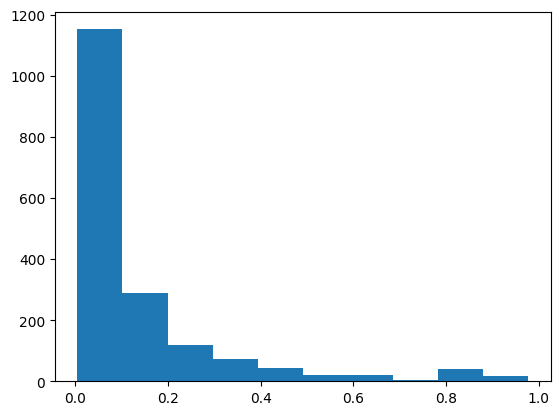

In [126]:
plt.hist(df['XG'])

In [127]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

variables = df.columns
input_variables = variables[variables != 'XG']

X = df[input_variables]
y = df['XG']
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

lgbm = LGBMRegressor(objective='regression', random_state=90)
search_spaces = {
    'boosting_type': Categorical(['gbdt', 'dart']), #no goss, although it was the best without bagging, as it doesnt support it
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'num_leaves': Integer(20, 70),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 8),
    'bagging_fraction': Real(0.5, 1.0),
    'bagging_freq': Integer(1, 5),
}

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=3,
    n_jobs=-1,
)

bayes_search.fit(X_train, y_train)

print(f"Best Bayesian Search Score: {bayes_search.best_score_:.5f}")
print(f"Best Bayesian Search Parameters: {bayes_search.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6228
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 25
[LightGBM] [Info] Start training from score -2.580603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\nrt\AppData\Local\Temp\ipykernel_11236\333571854.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


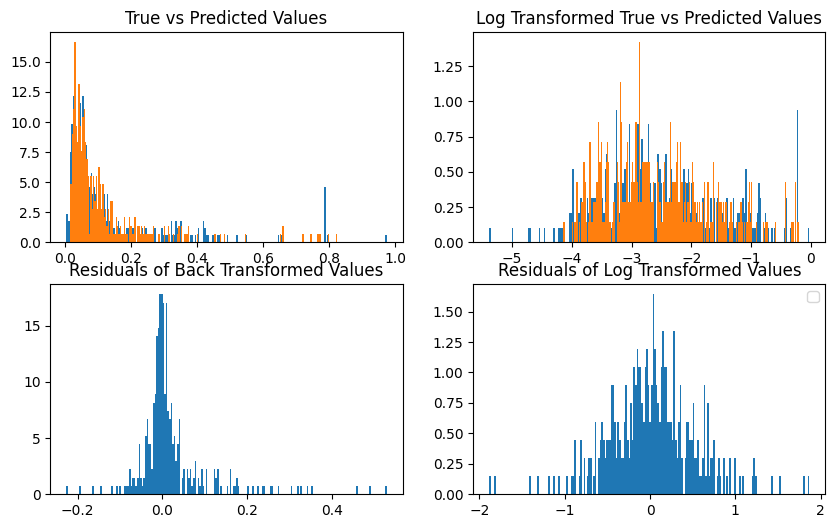

In [ ]:
import matplotlib.pyplot as plt

def mae(y_true, y_pred):
    return np.mean(abs((y_true - y_pred)))

new_params =  {'boosting_type': 'dart', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'num_leaves': 38, 'n_estimators': 328}
new_params =  {'boosting_type': 'dart', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'num_leaves': 38, 'n_estimators': 328}

new_params = bayes_search.best_params_
#both new params have mae of about 0.053

lgbm_best = LGBMRegressor(**new_params, objective='regression', random_state=30)

lgbm_best.fit(X_train, y_train)
y_score = lgbm_best.predict(X_test)

meow = mae(y_test, y_score)

y_back = np.exp(y_score)
y_back_test = np.exp(y_test)

meow_back = mae(y_back_test, y_back)

print(f"Mean Absolute Error (MAE): {meow_back}")
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0,0].hist(y_back_test, label='True Values', bins=200,density= True)
ax[0,0].hist(y_back, label='Predicted Values', bins=200, density = True)
ax[0,0].set_title('True vs Predicted Values')
ax[0,1].hist(y_test, bins=200, density=True)
ax[0,1].hist(y_score, bins=200, density=True)
ax[0,1].set_title('Log Transformed True vs Predicted Values')
ax[1,0].hist(y_back_test - y_back, bins=200, density=True)
ax[1,0].set_title('Residuals of Back Transformed Values')
ax[1,1].hist(y_test- y_score, bins=200, density=True)
ax[1,1].set_title('Residuals of Log Transformed Values')
plt.legend()

#0.04618892114190254 best, 
# lightgbm + no speed+ ball distances+bayes search + log y 
# OrderedDict([('bagging_fraction', 0.5), ('bagging_freq', 1), ('boosting_type', 'gbdt'), ('learning_rate', 0.038223831624696315), ('max_depth', 8), ('n_estimators', 167), ('num_leaves', 70)])


In [129]:
print(mae(y_back_test, y_back))


hist, bins = np.histogram(y_back_test, bins=100)
print(hist)

lgbm_best.feature_importances_

0.04618892114190254
[ 7 30 40 28 31 33 18 18 15 11  3 12 10  8  4  1  5  1  3  4  4  1  3  3
  2  2  1  4  1  2  2  2  3  2  5  3  0  2  1  1  1  2  3  3  1  1  0  2
  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  1  3  0  0  0  0
  0  1  0  0  0  0  0  0  8  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1]


array([418, 513, 196, 138, 331, 134, 101, 111, 110,  84,  94, 101, 101,
        49,  91,  86,  85,  71,  88,  81,  66, 102,  93, 134, 138],
      dtype=int32)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagg

C:\Users\nrt\AppData\Local\Temp\ipykernel_11236\854908239.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])


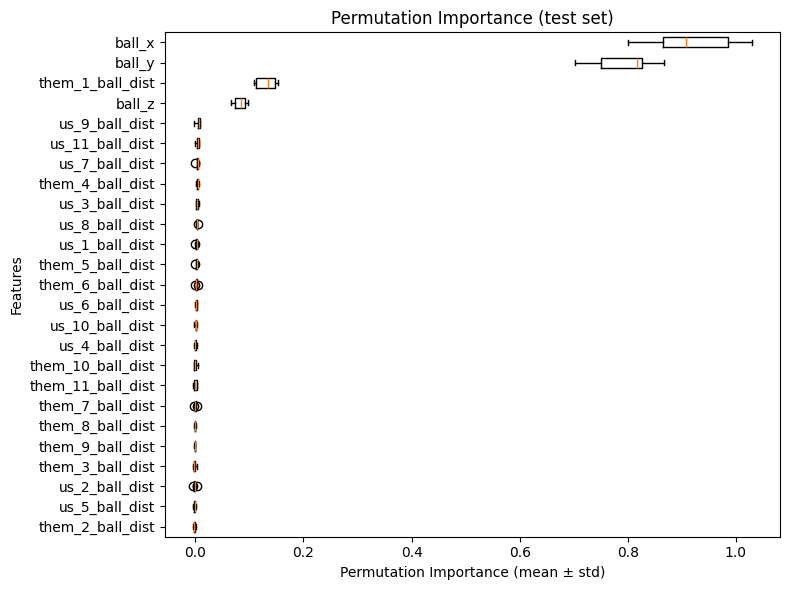

In [130]:
from sklearn.inspection import permutation_importance

result = permutation_importance(lgbm_best, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])
ax.set_title("Permutation Importance (test set)")
ax.set_xlabel("Permutation Importance (mean ± std)")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()


Index(['them_2_ball_dist', 'us_5_ball_dist', 'us_2_ball_dist',
       'them_3_ball_dist', 'them_9_ball_dist', 'them_8_ball_dist',
       'them_7_ball_dist', 'them_11_ball_dist', 'them_10_ball_dist',
       'us_4_ball_dist', 'us_10_ball_dist', 'us_6_ball_dist',
       'them_6_ball_dist', 'them_5_ball_dist', 'us_1_ball_dist',
       'us_8_ball_dist', 'us_3_ball_dist', 'them_4_ball_dist',
       'us_7_ball_dist', 'us_11_ball_dist', 'us_9_ball_dist', 'ball_z',
       'them_1_ball_dist', 'ball_y', 'ball_x'],
      dtype='object')


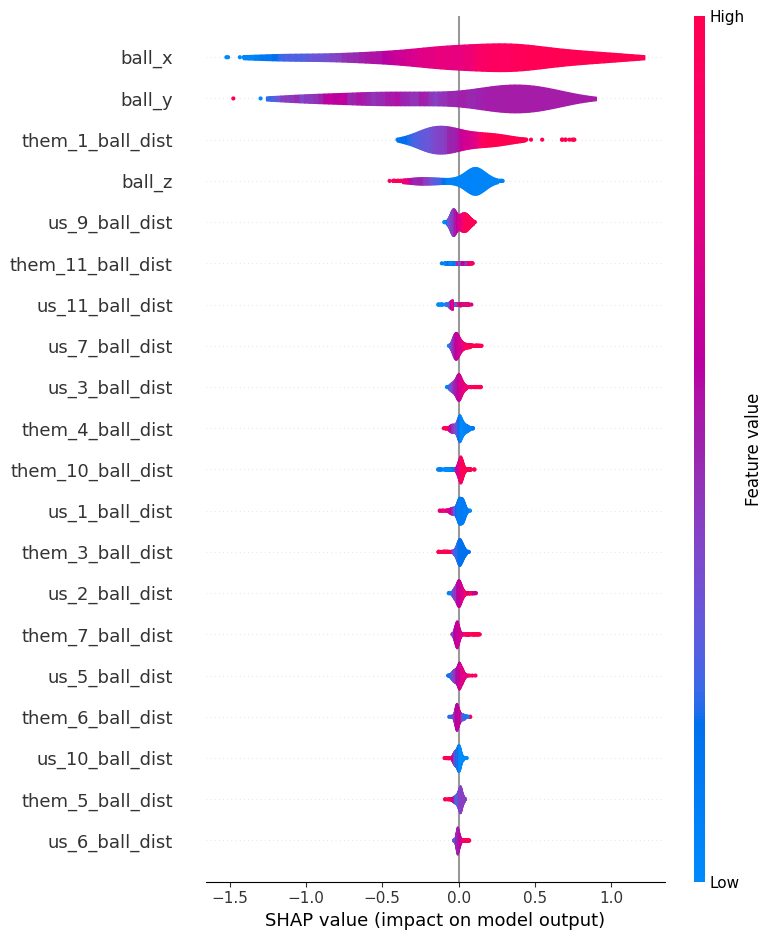

In [131]:
print(input_variables[sorted_idx])

import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(lgbm_best)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test, feature_names=input_variables, plot_type="violin")
plt.show()

## Trying data augmentation - using noise


In [5]:
noise = np.random.normal(0, 0.1, df.shape)
df_aug = df.copy() + noise
df_aug['XG'] = df['XG']  # Ensure the target variable remains unchanged
df_augmented = pd.concat([df, df_aug], ignore_index=True)
df_augmented.head()
#df.head()
print(df_augmented.isna().sum())



XG                    0
ball_x                0
ball_y                0
ball_z                0
us_1_ball_dist        0
them_1_ball_dist      0
us_2_ball_dist        0
them_2_ball_dist      0
us_3_ball_dist        0
them_3_ball_dist      0
us_4_ball_dist        0
them_4_ball_dist      0
us_5_ball_dist        0
them_5_ball_dist      0
us_6_ball_dist        0
them_6_ball_dist      0
us_7_ball_dist        0
them_7_ball_dist      0
us_8_ball_dist        0
them_8_ball_dist      0
us_9_ball_dist        0
them_9_ball_dist      0
us_10_ball_dist       0
them_10_ball_dist     0
us_11_ball_dist      30
them_11_ball_dist    82
dtype: int64


In [6]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

variables = df_augmented.columns
input_variables = variables[variables != 'XG']

X = df_augmented[input_variables]
y = df_augmented['XG']
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

lgbm = LGBMRegressor(objective='regression', random_state=90)
search_spaces = {
    'boosting_type': Categorical(['gbdt', 'dart']), #no goss, although it was the best without bagging, as it doesnt support it
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'num_leaves': Integer(20, 70),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 8),
    'bagging_fraction': Real(0.5, 1.0),
    'bagging_freq': Integer(1, 5),
}

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=search_spaces,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=3,
    n_jobs=-1,
)

bayes_search.fit(X_train, y_train)

print(f"Best Bayesian Search Score: {bayes_search.best_score_:.5f}")
print(f"Best Bayesian Search Parameters: {bayes_search.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.8228515174519165, np.int64(4), 'dart', 0.0013125749665122601, np.int64(3), np.int64(183), np.int64(44)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.6720974234276845, np.int64(4), 'gbdt', 0.01947682020261119, np.int64(5), np.int64(53), np.int64(56)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.633901781699949, np.int64(4), 'dart', 0.016793542763378393, np.int64(6), np.int64(84), np.int64(34)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.8872657900751415, np.int64(5), 'dart', 0.011264497679345465, np.int64(8), np.int64(155), np.int64(36)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.6026198993774433, np.int64(2), 'gbdt', 0.05271502491401292, np.int64(5), np.int64(123), np.int64(54)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(5), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.7174527526514843, np.int64(5), 'dart', 0.0018512890178319812, np.int64(8), np.int64(157), np.int64(69)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.9381416999341146, np.int64(4), 'dart', 0.016235706559504598, np.int64(7), np.int64(198), np.int64(49)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.566566422655665, np.int64(3), 'dart', 0.002427995675829867, np.int64(6), np.int64(105), np.int64(35)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.9637188961802781, np.int64(4), 'dart', 0.0215135799567867, np.int64(7), np.int64(86), np.int64(54)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.5749044125807629, np.int64(1), 'gbdt', 0.09540061869277314, np.int64(6), np.int64(132), np.int64(67)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.9253493169174527, np.int64(4), 'dart', 0.010407672731973443, np.int64(5), np.int64(67), np.int64(47)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.5011224385657757, np.int64(1), 'dart', 0.0068990440905970386, np.int64(3), np.int64(112), np.int64(52)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.7267569340528729, np.int64(2), 'dart', 0.0035013649280464, np.int64(6), np.int64(62), np.int64(54)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.947727922230958, np.int64(5), 'gbdt', 0.025703091322118638, np.int64(8), np.int64(95), np.int64(58)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.9194390721401038, np.int64(1), 'dart', 0.01607617368464436, np.int64(7), np.int64(171), np.int64(56)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('gbdt'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.8658380459163073, np.int64(1), 'gbdt', 0.09096019510175432, np.int64(4), np.int64(184), np.int64(58)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.7961199276680967, np.int64(2), 'dart', 0.026822750367544366, np.int64(5), np.int64(88), np.int64(62)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.7005316767629488, np.int64(5), 'gbdt', 0.01704736184450172, np.int64(4), np.int64(148), np.int64(55)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.7553066635459815, np.int64(4), 'dart', 0.03493211827946181, np.int64(8), np.int64(142), np.int64(34)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\nrt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, np.int64(1), np.str_('dart'), 0.1, np.int64(8), np.int64(200), np.int64(70)] before, using random point [0.8000868331995455, np.int64(4), 'gbdt', 0.027180163009788476, np.int64(5), np.int64(118), np.int64(30)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 2849, number of used features: 25
[LightGBM] [Info] Start training from score -2.555627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6228
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 25
[LightGBM] [Info] Start training from score -2.580603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\nrt\AppData\Local\Temp\ipykernel_17700\4099051785.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


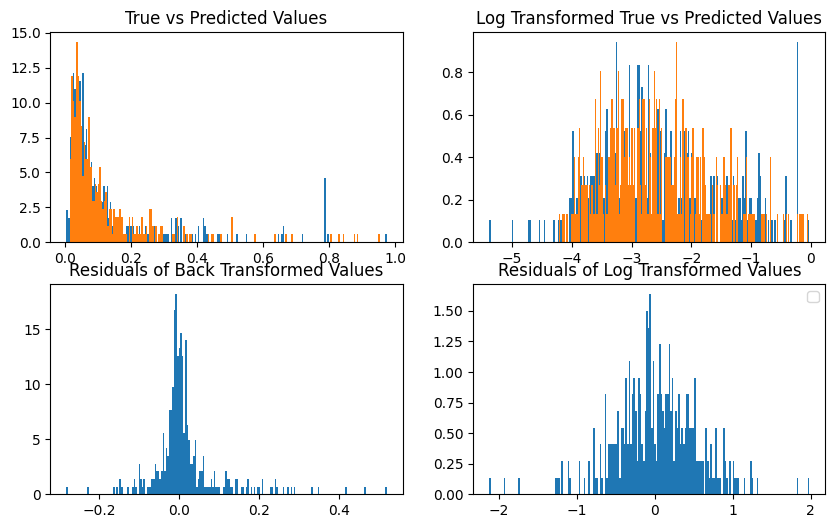

In [ ]:
import matplotlib.pyplot as plt

def mae(y_true, y_pred):
    return np.mean(abs((y_true - y_pred)))

new_params =  {'boosting_type': 'dart', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'num_leaves': 38, 'n_estimators': 328}
new_params =  {'boosting_type': 'dart', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'num_leaves': 38, 'n_estimators': 328}

new_params = bayes_search.best_params_
#both new params have mae of about 0.053

lgbm_best = LGBMRegressor(**new_params, objective='regression', random_state=30)

variables = df_augmented.columns
input_variables = variables[variables != 'XG']
X = df[input_variables]
y_log = np.log(df['XG'])
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
lgbm_best.fit(X_train, y_train)
y_score = lgbm_best.predict(X_test)

meow = mae(y_test, y_score)

y_back = np.exp(y_score)
y_back_test = np.exp(y_test)

meow_back = mae(y_back_test, y_back)

print(f"Mean Absolute Error (MAE): {meow_back}")
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0,0].hist(y_back_test, label='True Values', bins=200,density= True)
ax[0,0].hist(y_back, label='Predicted Values', bins=200, density = True)
ax[0,0].set_title('True vs Predicted Values')
ax[0,1].hist(y_test, bins=200, density=True)
ax[0,1].hist(y_score, bins=200, density=True)
ax[0,1].set_title('Log Transformed True vs Predicted Values')
ax[1,0].hist(y_back_test - y_back, bins=200, density=True)
ax[1,0].set_title('Residuals of Back Transformed Values')
ax[1,1].hist(y_test- y_score, bins=200, density=True)
ax[1,1].set_title('Residuals of Log Transformed Values')
plt.legend()

#0.04618892114190254 best, 
# lightgbm + no speed+ ball distances+bayes search + log y 
# OrderedDict([('bagging_fraction', 0.5), ('bagging_freq', 1), ('boosting_type', 'gbdt'), ('learning_rate', 0.038223831624696315), ('max_depth', 8), ('n_estimators', 167), ('num_leaves', 70)])

In [ ]:
def generate_XG(gbm_best, pickle_row, speed=True, ordered=False):
    '''

    inputs:
    picke_row (np.array): [ball_x, ball_y, ball_z, player_1_x, player_1_y, ..., player_22_y] (if speed is there, us_1_y, us_1_)
    speed (bool): whether speed is included in the input features 
    ordered (bool): whether players are ordered by closeness to ball, with home_1, away_1, home_2, order 
    '''

    if speed:
        xylist = [pickle_row[0], pickle_row[1], pickle_row[2]]  # ball_x, ball_y, ball_z

        xylist += [item for i in range(22) for item in (pickle_row[3 + i * 3], pickle_row[4 + i * 3])]
        xylist = np.array(xylist)
    else:
        xylist = pickle_row.copy()

    input = np.zeros(22 + 3)  # 22 players, each with x, y, z coordinates, plus ball_x, ball_y, ball_z
    input[0:3] = xylist[0:3]  # ball_x , ball_y, ball_z
    print(len(xylist))
    for i in range(1, 23):

        input[i+2] = np.sqrt((xylist[0] -xylist[2+i*2])**2+ (xylist[1]-xylist[2+i*2+1])**2)  # player_x^2 + player_y^2
        print(input)

    param = [('bagging_fraction', 0.5), ('bagging_freq', 1), ('boosting_type', 'gbdt'), ('learning_rate', 0.038223831624696315), ('max_depth', 8), ('n_estimators', 167), ('num_leaves', 70)]

    lgbm = LGBMRegressor(**new_params, objective='regression', random_state=30)
    return

def get_gbm_best():
    new_params =  {'boosting_type': 'dart', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'num_leaves': 38, 'n_estimators': 328}
    lgbm_best = LGBMRegressor(**new_params, objective='regression', random_state=30)
    return lgbm_best
test_row = [0, 0, 0]
test_row += [item for i in range(22) for item in (i, i+1, i+2)]  # Example row with ball_x=0, ball_y=0, ball_z=0 and players at (1,2), (3,4), ..., (21,22)  
generate_XG(np.array(test_row), speed=True, ordered=False)


    
#0.04618892114190254 best, 
# lightgbm + no speed+ ball distances+bayes search + log y 


47
[0.         0.         0.         1.41421356 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         1.41421356 2.82842712 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         1.41421356 2.82842712 4.24264069
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         1.41421356 2.82842712 4.24264069
 5.65685425 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0

IndexError: index 47 is out of bounds for axis 0 with size 47